In [81]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
from sklearn.model_selection import cross_validate
import seaborn as sns

# Suppress all sklearn FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Suppress all XGBoost UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [71]:
mohs = pd.read_csv('mohs_patients_10000.csv')

for i in mohs.dtypes.index:
    if mohs.dtypes[i] == 'object':
        mohs[i] = mohs[i].astype('category')

mohs['Complexity'] = mohs['Complexity'].map({'Simple': 0, 'Complex': 1})

,PatientID,Complexity,TumorType,Location,TumorDiameter_mm,HistologicSubtype,SpeaksEnglish,Age,Immunosuppressed
0,Patient_00001,0,Basal Cell Carcinoma,Ear,5.5,Basosquamous,English,62,No
1,Patient_00002,0,Melanoma in situ,Forehead,8.8,Infiltrative,English,89,No
2,Patient_00003,1,Squamous Cell Carcinoma,Forehead,11.4,Desmoplastic,Non-English,50,No
3,Patient_00004,0,Melanoma in situ,Forehead,4.1,Desmoplastic,English,45,No
4,Patient_00005,0,Basal Cell Carcinoma,Ear,3.0,Superficial,English,66,No
...,...,...,...,...,...,...,...,...,...
9995,Patient_09996,0,Basal Cell Carcinoma,Forehead,7.4,Infiltrative,English,44,No
9996,Patient_09997,1,Basal Cell Carcinoma,Nose,9.3,Keratoacanthoma-like,English,82,No
9997,Patient_09998,0,Basal Cell Carcinoma,Neck,3.4,Keratoacanthoma-like,English,85,No
9998,Patient_09999,0,Basal Cell Carcinoma,Eyelid,5.1,Morpheaform,Non-English,56,Yes


In [72]:
X = mohs.drop(columns=['Complexity','PatientID'], axis=1)
y = mohs['Complexity']

,TumorType,Location,TumorDiameter_mm,HistologicSubtype,SpeaksEnglish,Age,Immunosuppressed
0,Basal Cell Carcinoma,Ear,5.5,Basosquamous,English,62,No
1,Melanoma in situ,Forehead,8.8,Infiltrative,English,89,No
2,Squamous Cell Carcinoma,Forehead,11.4,Desmoplastic,Non-English,50,No
3,Melanoma in situ,Forehead,4.1,Desmoplastic,English,45,No
4,Basal Cell Carcinoma,Ear,3.0,Superficial,English,66,No
...,...,...,...,...,...,...,...
9995,Basal Cell Carcinoma,Forehead,7.4,Infiltrative,English,44,No
9996,Basal Cell Carcinoma,Nose,9.3,Keratoacanthoma-like,English,82,No
9997,Basal Cell Carcinoma,Neck,3.4,Keratoacanthoma-like,English,85,No
9998,Basal Cell Carcinoma,Eyelid,5.1,Morpheaform,Non-English,56,Yes


In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
xgb_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}
n=50
model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

In [70]:
### Regular Cross-Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(eval_metric='logloss', 
                         enable_categorical=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# 3. Perform 5-fold cross-validation
cv_results = cross_validate(
    estimator=xgb_clf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 4. Print mean + std for each metric
for metric in scoring:
    mean = cv_results[f'test_{metric}'].mean()

    print(f"{metric.capitalize():<9}: {mean:.4f}")



Accuracy : 0.8818
Precision: 0.8533
Recall   : 0.7195
F1       : 0.7805


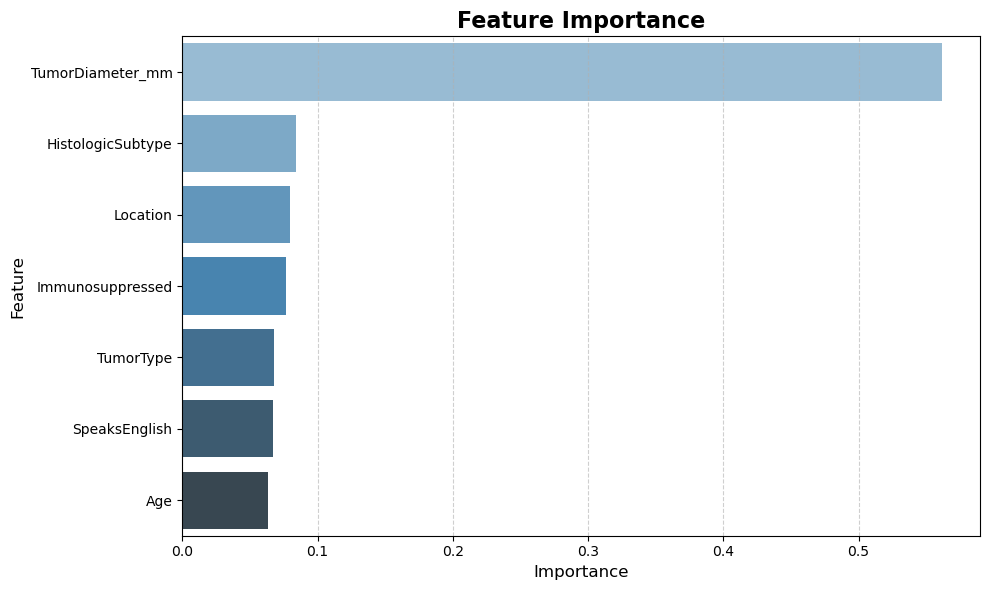

In [83]:
xgb_clf.fit(X_train, y_train)

importance = xgb_clf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df, 
    palette='Blues_d'
)

plt.title('Feature Importance', fontsize=16, weight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [57]:
### Tuning with GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(eval_metric='logloss', 
                         enable_categorical=True)

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [1,2,3,4,5,6,7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use roc_auc as scoring metric
scorer = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=scorer,
    refit=False,
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytre

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=5, subsampl

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=5, subsampl

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=1, subsample=0.8;

arn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=1, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=5, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=5, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=2, subsample=1.0; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=1, subsample=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=4, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=2, subsampl

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=2, subsample=1.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=7, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=6, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=4, subsample=1.0; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=3, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=4, subsample=1.0; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=7, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=4, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=6, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=7, subsample=0.8; to

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=1, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=2, subsample=0.8; to

In [90]:
import pandas as pd

# Get CV results as DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Extract the relevant metric columns
metrics_df = cv_results[[
    'params',
    'mean_test_roc_auc',
    'mean_test_accuracy',
    'mean_test_precision',
    'mean_test_recall',
    'mean_test_f1'
]]

metrics_sorted = metrics_df.sort_values(by='mean_test_roc_auc', ascending=False)

# Display top results
pd.set_option('display.max_colwidth', None)
best_by_roc_auc = metrics_df.sort_values(by='mean_test_roc_auc', ascending=False).iloc[0]
print("Best model by mean_test_precision:")
print(best_by_roc_auc)



Best model by mean_test_precision:
params                 {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 7, 'subsample': 0.8}
mean_test_roc_auc                                                                                                  0.908304
mean_test_accuracy                                                                                                  0.88775
mean_test_precision                                                                                                 0.93765
mean_test_recall                                                                                                   0.660114
mean_test_f1                                                                                                       0.774568
Name: 194, dtype: object


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'TumorType'),
  Text(1, 0, 'Location'),
  Text(2, 0, 'TumorDiameter_mm'),
  Text(3, 0, 'HistologicSubtype'),
  Text(4, 0, 'Age'),
  Text(5, 0, 'Immunosuppressed')])

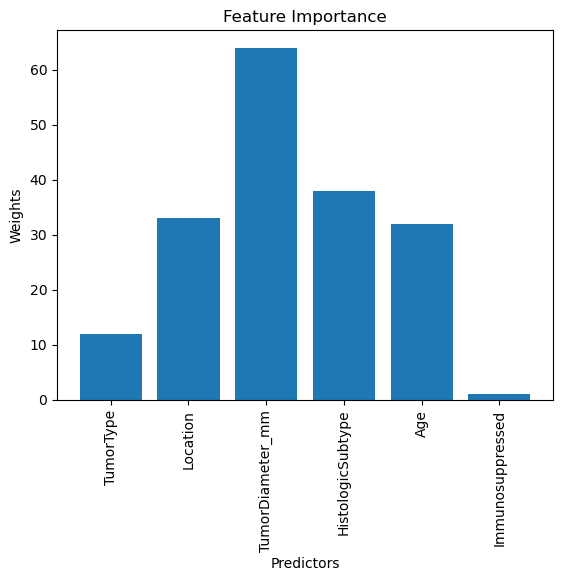

In [38]:
Predictors = best_model.get_booster().get_score(importance_type='weight').keys()
Weights = best_model.get_booster().get_score(importance_type='weight').values()

plt.bar(Predictors, Weights)
plt.xlabel('Predictors')
plt.ylabel('Weights')
plt.title('Feature Importance')
plt.xticks(rotation=90)